In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.optim as optim

import pennylane as qml
from pennylane import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from utils.tools import get_dataset, visualise_data, train_and_plot_accuracy, test_loop
from utils.models import NetCNN, NeuralNetwork, QNN, PGD

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
digits = [3, 5, 8, 9]
n_classes = len(digits)
n_px = 16

n_qubits = int(np.log2(n_px * n_px))
n_layers = 32

train_size = 10000
test_size = 2000

batch_size = 100
epochs = 30
lr = 1e-3

In [4]:
# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=train_size, test_size=test_size)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

In [5]:
# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_train[y_train == i])[0].squeeze(0) for i in range(len(digits))]
y_vis = digits

visualise_data(x_vis, y_vis)

In [6]:
model_CNN = NetCNN(n_px=n_px, n_classes=n_classes).to(device)
summary(model_CNN,input_size=(1,n_px,n_px))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
         MaxPool2d-2              [-1, 8, 8, 8]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                   [-1, 16]           4,112
            Linear-6                    [-1, 4]              68
Total params: 5,428
Trainable params: 5,428
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [7]:
model_feed_forward = NeuralNetwork(n_px=n_px, n_classes=n_classes).to(device)
summary(model_feed_forward, input_size=(1,n_px,n_px))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 256]               0
            Linear-2                   [-1, 32]           8,224
              ReLU-3                   [-1, 32]               0
            Linear-4                    [-1, 8]             264
              ReLU-5                    [-1, 8]               0
            Linear-6                    [-1, 4]              36
Total params: 8,524
Trainable params: 8,524
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [8]:
model_qml = QNN(n_qubits=n_qubits, n_classes=n_classes, n_layers=n_layers).to(device)
summary(model_qml, input_size=(1,n_px * n_px))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        TorchLayer-1                    [-1, 8]               0
            Linear-2                    [-1, 4]              36
Total params: 36
Trainable params: 36
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [9]:
train_and_plot_accuracy(model_CNN, train_loader, test_loader, epochs=epochs, lr=lr, device=device)

Epoch 5/30 | Train Loss: 0.1104 | Train Acc: 96.46% | Test Loss: 0.1076 | Test Acc: 96.60% | Learning Rate: 0.001000


Epoch 10/30 | Train Loss: 0.0752 | Train Acc: 97.62% | Test Loss: 0.0738 | Test Acc: 97.50% | Learning Rate: 0.001000


Epoch 15/30 | Train Loss: 0.0564 | Train Acc: 98.04% | Test Loss: 0.0605 | Test Acc: 97.85% | Learning Rate: 0.001000


Epoch 20/30 | Train Loss: 0.0453 | Train Acc: 98.40% | Test Loss: 0.0653 | Test Acc: 97.80% | Learning Rate: 0.001000


Epoch 25/30 | Train Loss: 0.0355 | Train Acc: 98.73% | Test Loss: 0.0471 | Test Acc: 98.20% | Learning Rate: 0.001000


Epoch 30/30 | Train Loss: 0.0319 | Train Acc: 98.86% | Test Loss: 0.0615 | Test Acc: 97.80% | Learning Rate: 0.001000

Training completed in 13.81 seconds.


In [10]:
train_and_plot_accuracy(model_feed_forward, train_loader, test_loader, epochs=epochs, lr=lr, device=device)

Epoch 5/30 | Train Loss: 0.2106 | Train Acc: 93.03% | Test Loss: 0.2111 | Test Acc: 93.30% | Learning Rate: 0.001000


Epoch 10/30 | Train Loss: 0.1443 | Train Acc: 95.41% | Test Loss: 0.1728 | Test Acc: 94.65% | Learning Rate: 0.001000


Epoch 15/30 | Train Loss: 0.1161 | Train Acc: 96.34% | Test Loss: 0.1593 | Test Acc: 94.85% | Learning Rate: 0.001000


Epoch 20/30 | Train Loss: 0.0956 | Train Acc: 96.99% | Test Loss: 0.1486 | Test Acc: 95.10% | Learning Rate: 0.001000


Epoch 25/30 | Train Loss: 0.0800 | Train Acc: 97.64% | Test Loss: 0.1417 | Test Acc: 95.55% | Learning Rate: 0.001000


Epoch 30/30 | Train Loss: 0.0668 | Train Acc: 97.93% | Test Loss: 0.1375 | Test Acc: 96.00% | Learning Rate: 0.001000

Training completed in 7.04 seconds.


In [11]:
model_qml = QNN(n_qubits=n_qubits, n_classes=n_classes, n_layers=n_layers).to("cpu")
train_and_plot_accuracy(model_qml, train_loader, test_loader, epochs=epochs, lr=lr, device="cpu")

Epoch 5/30 | Train Loss: 0.8368 | Train Acc: 82.90% | Test Loss: 0.7785 | Test Acc: 85.85% | Learning Rate: 0.001000


Epoch 10/30 | Train Loss: 0.5773 | Train Acc: 89.07% | Test Loss: 0.5418 | Test Acc: 90.40% | Learning Rate: 0.001000


Epoch 15/30 | Train Loss: 0.4468 | Train Acc: 91.07% | Test Loss: 0.4220 | Test Acc: 92.10% | Learning Rate: 0.001000


Epoch 20/30 | Train Loss: 0.3676 | Train Acc: 91.95% | Test Loss: 0.3480 | Test Acc: 92.50% | Learning Rate: 0.001000


Epoch 25/30 | Train Loss: 0.3137 | Train Acc: 93.02% | Test Loss: 0.2983 | Test Acc: 93.30% | Learning Rate: 0.001000


Epoch 30/30 | Train Loss: 0.2756 | Train Acc: 93.41% | Test Loss: 0.2617 | Test Acc: 93.75% | Learning Rate: 0.001000

Training completed in 2186.25 seconds.


## Adversarial attacks

In [12]:
def PGD(model, feats, labels, epsilon=0.1, alpha=None, num_iter=10):
    if alpha is None:
        alpha = epsilon/num_iter
    
    model.eval()  # Ensure model is in eval mode
    feats = feats.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    
    # Start with zero perturbation
    delta = torch.zeros_like(feats, requires_grad=True).to(device)
    
    for t in range(num_iter):
        outputs = model(feats + delta)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        
        # Update delta and clamp it to epsilon
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    
    return delta.detach()

In [13]:
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
perturbations = PGD(model=model_CNN, feats=x_perturb, labels=y_perturb, epsilon=0.18, alpha=0.01, num_iter=100)

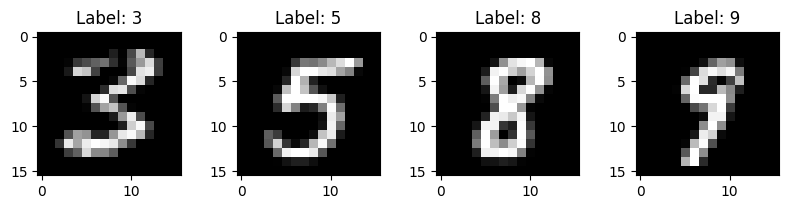

In [14]:
# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[0].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits

visualise_data(x_vis, y_vis)

In [15]:
x_perturb = x_perturb + perturbations

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[0].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits

visualise_data(x_vis, y_vis)

In [16]:
loss_fn = nn.CrossEntropyLoss()

# Evaluate model on adversarial examples
def evaluate_under_attack(model, base_feats, labels, epsilons, alpha, num_iter):
    acc_list = []

    for eps in epsilons:
        perturb = PGD(model, base_feats, labels, epsilon=eps, alpha=alpha, num_iter=num_iter)
        x_adv = (base_feats + perturb).clamp(0, 1)  # Clamp to valid pixel range
        adv_loader = DataLoader(TensorDataset(x_adv, labels), batch_size=batch_size)
        _, acc = test_loop(adv_loader, model, loss_fn, device)
        acc_list.append(acc)

    return acc_list

# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100
model_qml.to(device)
# Evaluate both models
accs_cnn = evaluate_under_attack(model_CNN, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_neural = evaluate_under_attack(model_feed_forward, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_qml = evaluate_under_attack(model_qml, x_perturb, y_perturb, epsilons, alpha, num_iter)

In [17]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN Model')
plt.plot(epsilons, accs_neural, 'ro-', label='Neural Model')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN Model')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon under PGD Attack')
plt.legend()
plt.grid(True)
plt.show()

### Quantum to classical transfer attack

In [ ]:
# Evaluate model on adversarial examples
def evaluate_under_attack(model, base_feats, labels, epsilons, alpha, num_iter):
    acc_list = []

    for eps in epsilons:
        perturb = PGD(model_qml, base_feats, labels, epsilon=eps, alpha=alpha, num_iter=num_iter)
        x_adv = (base_feats + perturb).clamp(0, 1)  # Clamp to valid pixel range
        adv_loader = DataLoader(TensorDataset(x_adv, labels), batch_size=batch_size)
        _, acc = test_loop(adv_loader, model, loss_fn, device)
        acc_list.append(acc)

    return acc_list

# Settings
epsilons = np.linspace(0, 0.2, 10).numpy() 
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 10
model_qml.to(device)
# Evaluate both models
accs_cnn = evaluate_under_attack(model_CNN, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_neural = evaluate_under_attack(model_feed_forward, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_qml = evaluate_under_attack(model_qml, x_perturb, y_perturb, epsilons, alpha, num_iter)

In [ ]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN Model')
plt.plot(epsilons, accs_neural, 'ro-', label='Neural Model')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN Model')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon under transfer attack (quantum to classical)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Evaluate model on adversarial examples
def evaluate_under_attack(model, base_feats, labels, epsilons, alpha, num_iter):
    acc_list = []

    for eps in epsilons:
        perturb = PGD(model_CNN, base_feats, labels, epsilon=eps, alpha=alpha, num_iter=num_iter)
        x_adv = (base_feats + perturb).clamp(0, 1)  # Clamp to valid pixel range
        adv_loader = DataLoader(TensorDataset(x_adv, labels), batch_size=batch_size)
        _, acc = test_loop(adv_loader, model, loss_fn, device)
        acc_list.append(acc)

    return acc_list

# Settings
epsilons = np.linspace(0, 0.2, 10).numpy()  
x_perturb = x_test.to(device)
y_perturb = y_test.to(device)
alpha = 1e-2
num_iter = 100
model_qml.to(device)
# Evaluate both models
accs_cnn = evaluate_under_attack(model_CNN, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_neural = evaluate_under_attack(model_feed_forward, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_qml = evaluate_under_attack(model_qml, x_perturb, y_perturb, epsilons, alpha, num_iter)

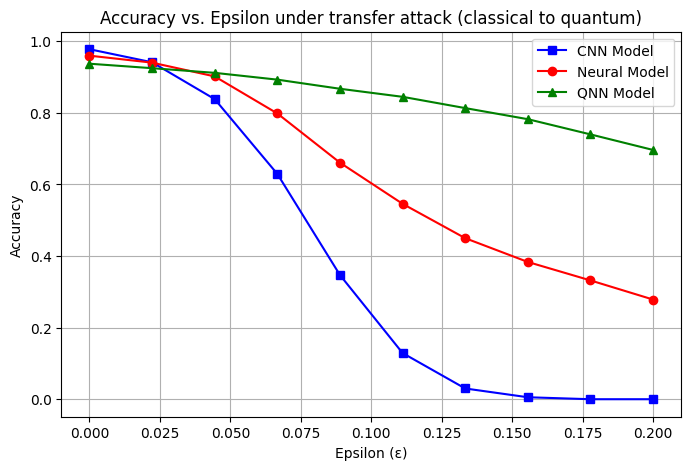

In [21]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN Model')
plt.plot(epsilons, accs_neural, 'ro-', label='Neural Model')
plt.plot(epsilons, accs_qml, 'g^-', label='QNN Model')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon under transfer attack (classical to quantum)')
plt.legend()
plt.grid(True)
plt.show()